In [175]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import gamma
from scipy.misc import factorial
from matplotlib import animation, rc
from IPython.display import HTML
import base64
import cv2 as cv

# Population Receptive Field Estimation Technique Simulation

The aim of this computational neuroscience research project is to develope and simulate novel neuroimaging techniques for estimating PRF of human visual field using simulation.
The outline of the work can be summed up as such,

* Create stimulus data
* Retinotopic Mapping
* Find coressponding Neuronal Response
* Assume an HRF model
* Convolve HRF with Neuronal Respose
* Add gaussian noise
* Estimate the assumed PRF from the generated noisy data
* Compare Assumed model with estimations
* Repeat with better stimulus protocol

# 1. Stimulus Generation
First we are going to generate the stimulus protocol.

### Creating bar stimulus 3D array

In [176]:
radius = 10
precession = 0.1
barWidth = radius / 4
angles = [-90, 45, -180, 315, 90, 225, 0, 135]
nFrames = len(angles)*3



X = Y = np.arange(-radius, radius + precession, precession)
lenngth = len(X)
stim = np.zeros((nFrames, lenngth, lenngth))

f = 0
for angle in angles:
    for k in range(3):
        for i, x in enumerate(X):
            for j, y in enumerate(Y):
                if np.sin(np.deg2rad(angle))*x - np.cos(np.deg2rad(angle))*y <= (0.5-0.5*k)*radius + barWidth:
                    if np.sin(np.deg2rad(angle))*x - np.cos(np.deg2rad(angle))*y >= (0.5-0.5*k)*radius - barWidth:
                        stim[f, j, i] = 1
        # updates the frame
        f = f + 1
        

### Creating animation

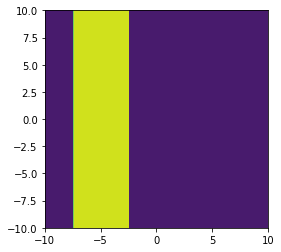

In [177]:
fig = plt.figure(figsize=(4, 4))
ax = plt.axes()  

# Animation function
def animate(i): 
    z = stim[i,:,:]
    cont = plt.contourf(X, Y, z)

    return cont  

anim = animation.FuncAnimation(fig, animate, frames=nFrames)

anim.save('stimulus.mp4', writer = 'ffmpeg', fps=2, codec='libx264')

with open('stimulus.mp4', 'rb') as f:
    video_tag = '<video controls alt="test" src="data:video/x-m4v;base64,{0}">'.format(base64.b64encode(f.read()).decode('utf-8'))

### Description and presentation
Drifting bar apertures at various orientations used in Dumoulin(2007) paper; The bar width subtended 1/4th of the stimulus radius. Four bar orientations and two different motion directions for each bar were used, giving a total of 8 different bar with 3 diffrent location which gives 24 configurations within a given scan as shown bellow.
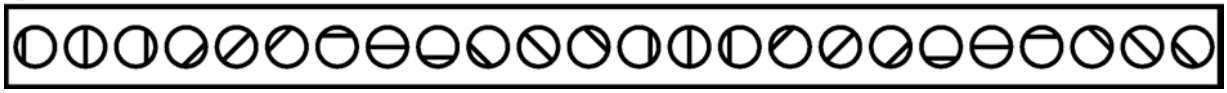

In [178]:
HTML(video_tag)

### Plot overal visual feild covered

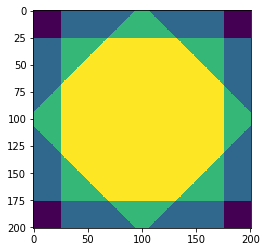

In [179]:
shape2D = (len(X), len(Y))
proj2D = np.zeros(shape2D)
for i in range(nFrames):
    proj2D = proj2D + (stim[i, :, :]).reshape(shape2D)
    
plt.imshow(proj2D)

# 2. Retinotopic Mapping
The retinotopic mapping can be moddeled using the log-polar transformation $dst( \rho , \phi ) = src(x, y)$ which emulates the human “foveal” vision where,

$$
\begin{array}{l}
I = (dx,dy) = (x - center.x,y - center.y) \\
\rho = M \cdot ln(\texttt{magnitude} (I)) \\
\phi = Ky \cdot \texttt{angle} (I) \\
M = src.cols / log_e(maxRadius) \\
Ky = src.rows / 360
\end{array}
$$

M – Magnitude scale parameter. It determines the radius of the bounding circle to transform too.

Center – The transformation center; where the output precision is maximal.

### Demonstration

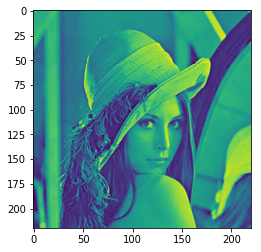

In [190]:
img_test = cv.imread('lenna.png', 0)
plt.imshow(img_test)

(220, 220)


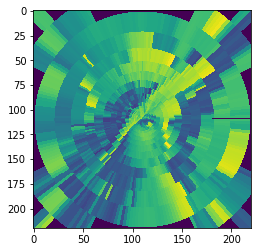

In [191]:
M = 5
center = (img_test.shape[0]/2, img_test.shape[1]/2)

warped_img = cv.logPolar(img_test, center, M, cv.WARP_FILL_OUTLIERS)
back_img = cv.logPolar(warped_img, center, M, cv.WARP_INVERSE_MAP + cv.WARP_FILL_OUTLIERS)

print(warped_img.shape)
plt.imshow(back_img)

### Stimulus Mapping

In [192]:
M = 5
center = (stim.shape[1]/2, stim.shape[2]/2)
mapped_img = np.zeros(stim.shape)

for frame in range(nFrames):
    img = stim[frame, :, :]
    logpolar_img = cv.logPolar(img, center, M, cv.WARP_FILL_OUTLIERS)
    mapped_img[frame, :, :] = cv.logPolar(logpolar_img, center, M, cv.WARP_INVERSE_MAP + cv.WARP_FILL_OUTLIERS)

### Plot overal visual feild covered

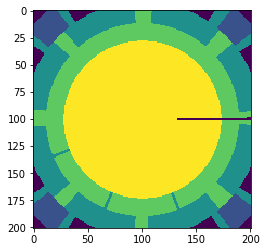

In [193]:
shape2D = (stim.shape[1], stim.shape[1])
proj2D = np.zeros(shape2D)
for i in range(nFrames):
    proj2D = proj2D + (mapped_img[i, :, :]).reshape(shape2D)
    
plt.imshow(proj2D)

### Animation Creatiion

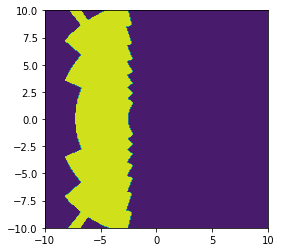

In [194]:
fig = plt.figure(figsize=(4, 4))
ax = plt.axes()  

# Animation function
def animate(i): 
    z = mapped_img[i,:,:]
    cont = plt.contourf(X, Y, z)

    return cont  

anim = animation.FuncAnimation(fig, animate, frames=nFrames)

anim.save('mappedStimulus.mp4', fps=2, codec='libx264')

with open('mappedStimulus.mp4', 'rb') as f:
    video_tag = '<video controls alt="test" src="data:video/x-m4v;base64,{0}">'.format(base64.b64encode(f.read()).decode('utf-8'))

In [195]:
HTML(video_tag)

# 3. Neuronal Response

# 4. HRF Modelling